In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



In [44]:
df = pd.read_csv('./data/Telco Customer Churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
# print(df.head())
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# errors='coerce' is a good approach to handle non-numeric values by replacing them with NaN.

df.replace(r'^\s+$', np.nan, regex=True, inplace=True)
# drop customerID column because this will not help in prediction and cause trouble in one hot encoding
df.drop('customerID', axis=1, inplace=True)




In [45]:
def handle_missing_values(df, option : str='mean'):
    """Fill missing values in data frame in place"""
    
    missing_values = df.isna().sum()
    # print(missing_values)

    # Check if there are any missing values
    if missing_values.any():
        print("There are missing values in the dataset.")
        # Display the count of missing values for each column
        # find the columns with missing values
        columns_with_missing_values = df.columns[missing_values > 0]
        print("Missing values per column:")
        print(missing_values[columns_with_missing_values])

        # fix the missing values
        # we can use df.replace(to_replace=' ', value=-1) to replace all missing values with -1
        for column in columns_with_missing_values:

            if option == 'drop':
                df.dropna()
            elif option == 'mean':
                df[column].fillna(df[column].mean(), inplace=True)
            elif option == 'median':
                df[column].fillna(df[column].median(), inplace=True)
            elif option == 'mode':
                df[column].fillna(df[column].mode()[0], inplace=True)
            elif option == 'linear':
                df[column].interpolate(method='linear', limit_direction='forward', inplace=True)
            elif option == 'quadratic':
                df[column].interpolate(method='quadratic', limit_direction='forward', inplace=True)
            elif option == 'cubic':
                df[column].interpolate(method='cubic', limit_direction='forward', inplace=True)
            elif option == 'spline':
                df[column].interpolate(method='spline', order=3, limit_direction='forward', inplace=True)
        
        print("Missing values per column are fixed\n")

    else:
        print("There are no missing values in the dataset.\n")
       


In [46]:
def normalize_numeric_data(df, numeric_cols):
    """Normalize numeric columns in dataframe in place"""

    from sklearn.preprocessing import MinMaxScaler


    # print(numeric_cols)
    scaler = MinMaxScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])



In [47]:

def one_hot_encode(df, categorical_cols):
    """One hot encode categorical columns in dataframee"""
    one_hot_encoded_data  = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    categorical_cols = one_hot_encoded_data.select_dtypes(exclude=np.number).columns.tolist()
    label_encode(one_hot_encoded_data, categorical_cols)

    return one_hot_encoded_data 

    
def label_encode(df, categorical_cols):
    """Label encode categorical columns in dataframe in place"""

    # print(categorical_cols)
    
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])
        

In [48]:

label_col = df.columns[-1]


# Split into feature and label data
X = df.drop(columns=[label_col])
y = df[label_col]

numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
# Exclude columns with binary data
numeric_cols = [col for col in numeric_cols if len(X[col].unique()) > 2]
# print(numeric_cols)

categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()
# add the binary column back to the list of categorical columns
binary_cols =  [col for col in numeric_cols if len(X[col].unique()) == 2]
categorical_cols.extend(binary_cols)
X = one_hot_encode(X, categorical_cols)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)
# random_state is the seed used by the random number generator
# keeping the train and test data separate to avoid data leakage

handle_missing_values(X_train, option='mean')
handle_missing_values(X_test, option='mean')


normalize_numeric_data(X_train, numeric_cols)
normalize_numeric_data(X_test, numeric_cols)

# categorical_cols_train = X_train.select_dtypes(exclude=np.number).columns.tolist()
# # add the binary column back to the list of categorical columns
# binary_cols_train =  [col for col in numeric_cols if len(X_train[col].unique()) == 2]
# categorical_cols_train.extend(binary_cols_train)

# categorical_cols_test = X_test.select_dtypes(exclude=np.number).columns.tolist()
# # add the binary column back to the list of categorical columns
# binary_cols_test =  [col for col in numeric_cols if len(X_test[col].unique()) == 2]
# categorical_cols_test.extend(binary_cols_test)



# X_train = one_hot_encode(X_train, categorical_cols_train)
# X_test = one_hot_encode(X_test, categorical_cols_test)

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

There are missing values in the dataset.
Missing values per column:
TotalCharges    8
dtype: int64
Missing values per column are fixed

There are missing values in the dataset.
Missing values per column:
TotalCharges    3
dtype: int64
Missing values per column are fixed



In [49]:
def get_top_score_feature_df(X, y, k=15):
    """Get the top k features with the highest score
        Return a new dataframe with the top k features
    """
    # todo: need to implement this function
    from sklearn.feature_selection import SelectKBest, mutual_info_classif

    selector = SelectKBest(mutual_info_classif, k=k)
    
    # Get the scores
    selector.fit(X, y)
    scores = selector.scores_

    df_scores = pd.DataFrame(scores, columns=["Score"], index=X.columns)
    df_scores = df_scores.sort_values(by="Score", ascending=False)

    # keep the top k features of the df DataFrame
    top_score_feature_X = X[df_scores.index[:k]]
    # top_score_feature_df doesn't have the label column


    # Plot the scores
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 10))
    plt.barh(df_scores.index, df_scores["Score"])
    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()
    
    return top_score_feature_X

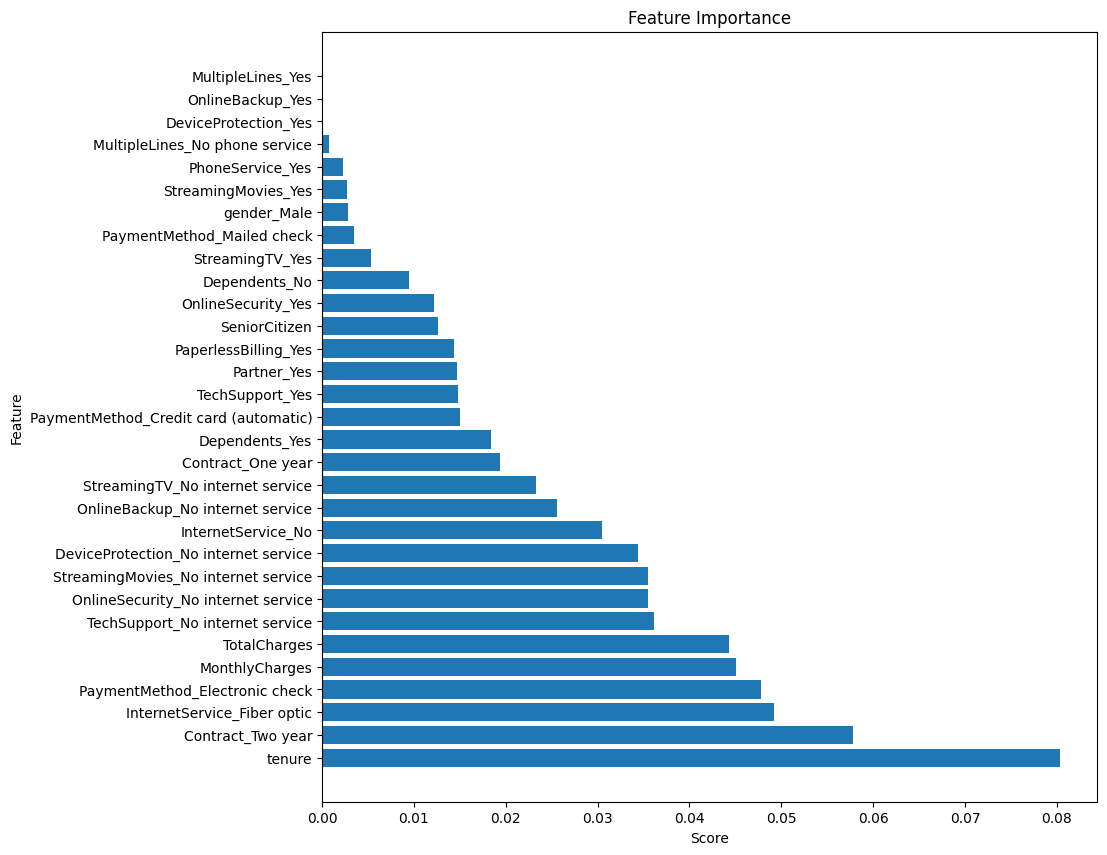

In [75]:
X_train = get_top_score_feature_df(X_train, y_train, k=20)

# keep only the top k features in the test data from the train data
X_test = X_test[X_train.columns]


In [51]:

def logisticRegressionLibrary(X_train, y_train, X_test, y_test):
    """Logistic Regression"""
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Logistic Regression")
    print("Accuracy: ", accuracy_score(y_test, y_pred)* 100)
    print("Precision: ", precision_score(y_test, y_pred) * 100)
    print("Recall: ", recall_score(y_test, y_pred) * 100)
    print("F1: ", f1_score(y_test, y_pred) * 100)
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print("\n\n")


In [73]:
class CustomLogisticRegression:
    """Custom Logistic Regression

    Parameters
    ----------
    learning_rate : float, default=0.01
        Learning rate for gradient descent.

    num_iterations : int, default=1000
        Number of iterations for gradient descent.

    verbose : bool, default=False
        Print the progress of training if True.

    Attributes
    ----------
    weights : 1d-array
        Weights after fitting the model.

    bias : float
        Bias after fitting the model.


    returns
    -------
    y_pred_class : 1d-array
        Predictions using the trained model.


    """
    def __init__(self, learning_rate=0.01, num_iterations=1000, verbose=False):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.verbose = verbose
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """Fit the model using training data"""

        # Initialize the parameters
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        # Gradient descent
        for i in range(self.num_iterations):
            
            linear_model = np.dot(X, self.weights)      # y hat = Xw
            
            # Predictions using sigmoid function
            y_pred = self.sigmoid(linear_model)

            # Compute gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))

            # Update parameters
            self.weights -= self.learning_rate * dw     # w = w - alpha * dw

            if self.verbose and i % 100 == 0:
                print(f'Iteration {i}, weights: {self.weights}, bias: {self.bias}')



    def predict(self, X):
        """Predict using the trained model"""
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_model)
        y_pred_class = [1 if i > 0.5 else 0 for i in y_pred]
        return y_pred_class




    def accuracy(self, y_true, y_pred):
        """Compute accuracy"""
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy
    
    def precision(self, y_true, y_pred):
        """Compute precision"""
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        precision = TP / (TP + FP)
        return precision
    
    def recall(self, y_true, y_pred):
        """Compute recall"""
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        recall = TP / (TP + FN)
        return recall
    
    def f1_score(self, y_true, y_pred):
        """Compute f1 score"""
        precision = self.precision(y_true, y_pred)
        recall = self.recall(y_true, y_pred)
        f1_score = 2 * precision * recall / (precision + recall)
        return f1_score
    

In [76]:
customRegressionModel = CustomLogisticRegression(learning_rate=0.1, num_iterations=1000, verbose=False)
customRegressionModel.fit(X_train, y_train)
y_pred = customRegressionModel.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("Logistic Regression")
print("Accuracy: ", accuracy_score(y_test, y_pred)* 100)
print("Precision: ", precision_score(y_test, y_pred) * 100)
print("Recall: ", recall_score(y_test, y_pred) * 100)
print("F1: ", f1_score(y_test, y_pred) * 100)
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("\n\n")

Logistic Regression
Accuracy:  79.4889992902768
Precision:  63.28358208955224
Recall:  56.08465608465608
F1:  59.46704067321178
Confusion Matrix: 
 [[908 123]
 [166 212]]



